In [1]:
import torch
from pyqcu.ascend import dslash
from pyqcu.ascend.define import *
# latt_size = (32, 32, 32, 32)
# latt_size = (32, 32, 16, 16)
# latt_size = (16, 16, 16, 32)
# latt_size = (16, 16, 16, 16)
latt_size = (16, 16, 8, 8)
# latt_size = (8, 16, 16, 32)
# latt_size = (32, 32, 32, 32)
# latt_size = (32, 32, 32, 64)
# latt_size = (4, 8, 8, 8)
# latt_size = (8, 8, 8, 4)
# latt_size = (16, 8, 8, 8)
# latt_size = (8, 8, 8, 16)
# latt_size = (8, 8, 8, 8)
# latt_size = (4, 4, 4, 4)
# latt_size = (2, 2, 2, 2)
# mass = -3.5
# mass = -0.8
# mass = -0.5
# mass = 0.05
# mass = 0.0
mass = -0.05
# kappa = 0.4
# kappa = 0.125
# kappa = 0.5
kappa = 1 / (2 * mass + 8)
dtype = torch.complex128
# dtype = torch.complex64
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
# Initialize lattice gauge theory
wilson = dslash.wilson_mg(
    latt_size=latt_size,
    kappa=kappa,
    dtype=dtype,
    device=device,
    verbose=False
)
clover = dslash.clover(
    latt_size=latt_size,
    kappa=kappa,
    dtype=dtype,
    device=device,
    verbose=False
)
U = wilson.generate_gauge_field(sigma=0.1, seed=42)

wilson.check_su3(U)
clover_term = clover.make_clover(U=U)
clover_term = torch.zeros_like(clover_term) # just for test, just wilson

b = torch.randn(4, 3, latt_size[3], latt_size[2], latt_size[1], latt_size[0],
                dtype=dtype, device=device)
verbose = True
tol = 1e-6

Using device: cuda


In [2]:
hopping_plus_list = []
hopping_minus_list = []
for ward in range(4):
    hopping_plus_list.append(wilson.give_hopping_plus(ward=ward, U=U))
    hopping_minus_list.append(wilson.give_hopping_minus(ward=ward, U=U))
Ab = wilson.give_wilson(src=b, U=U, with_I=False)
_Ab = torch.zeros_like(b)
for ward in range(4):
    _Ab += wilson.give_wilson_plus(ward=ward, src=b.reshape(
        [12]+list(U.shape[-4:])), hopping=hopping_plus_list[ward]).reshape([4, 3]+list(U.shape[-4:]))
    _Ab += wilson.give_wilson_minus(ward=ward, src=b.reshape(
        [12]+list(U.shape[-4:])), hopping=hopping_minus_list[ward]).reshape([4, 3]+list(U.shape[-4:]))
print(torch.norm(Ab-_Ab).item()/torch.norm(Ab).item())

2.1672823749344572e-16


In [3]:
from pyqcu.ascend import inverse
mg = inverse.mg(b=b, wilson=wilson, U=U,
                clover=clover, clover_term=clover_term, tol=tol, verbose=verbose)
mg.init()

Building grid list:
  Level 0: 16x16x8x8
  Level 1: 8x8x4x4
  Level 2: 4x4x2x2
self.grid_list:[[16, 16, 8, 8], [8, 8, 4, 4], [4, 4, 2, 2]]
Norm of b:496.8489190829809
Norm of r:702.0913388519872
Norm of x0:442.665398691082
BICGSTAB-Iteration 0: Residual = 1.209109e+02, Time = 0.013880 s
BICGSTAB-Iteration 1: Residual = 3.965653e+01, Time = 0.012899 s
BICGSTAB-Iteration 2: Residual = 6.257557e+01, Time = 0.012987 s
BICGSTAB-Iteration 3: Residual = 1.322394e+01, Time = 0.013030 s
BICGSTAB-Iteration 4: Residual = 9.145184e+00, Time = 0.012964 s
BICGSTAB-Iteration 5: Residual = 5.587011e+00, Time = 0.012822 s
BICGSTAB-Iteration 6: Residual = 4.698281e+00, Time = 0.013635 s
BICGSTAB-Iteration 7: Residual = 6.961979e+00, Time = 0.012840 s
BICGSTAB-Iteration 8: Residual = 3.633840e+00, Time = 0.012424 s
BICGSTAB-Iteration 9: Residual = 2.961545e+00, Time = 0.013105 s
BICGSTAB-Iteration 10: Residual = 2.157910e+00, Time = 0.013122 s
BICGSTAB-Iteration 11: Residual = 1.743363e+00, Time = 0.0129

In [4]:
def matvec(src: torch.Tensor, U: torch.Tensor = U, clover_term: torch.Tensor = clover_term) -> torch.Tensor:
    return wilson.give_wilson(src, U)+clover.give_clover(clover_term=clover_term, src=src)


def _matvec(src: torch.Tensor) -> torch.Tensor:
    return mg.op_list[0].matvec(src=src)

In [5]:
%%time
%time Ab = matvec(b)
%time _Ab = _matvec(b)
print(torch.norm(U).item())
print(torch.norm(clover_term).item())
print(torch.norm(Ab).item())
print(torch.norm(_Ab).item())
print(torch.norm(Ab-_Ab).item()/torch.norm(_Ab).item())

CPU times: user 8.19 ms, sys: 0 ns, total: 8.19 ms
Wall time: 6.97 ms
CPU times: user 3.96 ms, sys: 0 ns, total: 3.96 ms
Wall time: 5.15 ms
443.40500673763256
0.0
497.0232896989116
497.0232896989116
1.394175096325101e-16
CPU times: user 63.4 ms, sys: 19 μs, total: 63.4 ms
Wall time: 62 ms


In [6]:
%time Ab = matvec(b)
%time _Ab = _matvec(b)

CPU times: user 8.04 ms, sys: 0 ns, total: 8.04 ms
Wall time: 6.9 ms
CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 3.84 ms


In [7]:
b0 = mg.b_list[0]
b1 = inverse.restrict(
    local_ortho_null_vecs=mg.lonv_list[0], fine_vec=b0)
_b0 = inverse.prolong(local_ortho_null_vecs=mg.lonv_list[0], coarse_vec=b1)
_b1 = inverse.restrict(
    local_ortho_null_vecs=mg.lonv_list[0], fine_vec=_b0)
print(_b1.flatten()[:100]/b1.flatten()[:100])

restrict:shape,coarse_dof:(torch.Size([24, 12, 4, 2, 4, 2, 8, 2, 8, 2]), 24)
EeTtZzYyXx,eTtZzYyXx->ETZYX
prolong:shape,fine_dof:(torch.Size([24, 12, 4, 2, 4, 2, 8, 2, 8, 2]), 12)
EeTtZzYyXx,ETZYX->eTtZzYyXx
restrict:shape,coarse_dof:(torch.Size([24, 12, 4, 2, 4, 2, 8, 2, 8, 2]), 24)
EeTtZzYyXx,eTtZzYyXx->ETZYX
tensor([1.0000+1.2939e-16j, 1.0000+2.2714e-16j, 1.0000-3.1399e-16j,
        1.0000-7.7042e-17j, 1.0000-1.1070e-16j, 1.0000+6.7196e-16j,
        1.0000-1.2328e-16j, 1.0000-3.5371e-18j, 1.0000+6.4565e-16j,
        1.0000-4.1410e-17j, 1.0000+1.3876e-17j, 1.0000+6.5091e-16j,
        1.0000-6.9119e-18j, 1.0000-1.2675e-16j, 1.0000-1.2746e-16j,
        1.0000-2.1420e-17j, 1.0000-3.6199e-17j, 1.0000+2.0025e-17j,
        1.0000-3.7059e-16j, 1.0000-2.4636e-16j, 1.0000+1.4831e-16j,
        1.0000-5.3918e-16j, 1.0000+1.3745e-16j, 1.0000-7.8988e-16j,
        1.0000-4.1280e-16j, 1.0000-5.8443e-18j, 1.0000+3.0439e-17j,
        1.0000-5.1594e-16j, 1.0000-1.0492e-16j, 1.0000-2.8424e-16j,
        

In [21]:
# _x = inverse.cg(b=b, matvec=matvec, tol=tol, verbose=verbose)
_x = inverse.bicgstab(b=b, matvec=_matvec, tol=tol, verbose=verbose)
# _x = inverse.bicgstab(b=b, matvec=mg.op_list[0].matvec, tol=tol, verbose=verbose)

Norm of b:442.82798787465305
Norm of r:666.2446915331211
Norm of x0:443.74610024546007
BICGSTAB-Iteration 0: Residual = 1.432776e+02, Time = 0.012692 s
BICGSTAB-Iteration 1: Residual = 6.014693e+01, Time = 0.013400 s
BICGSTAB-Iteration 2: Residual = 6.568701e+01, Time = 0.012608 s
BICGSTAB-Iteration 3: Residual = 3.979020e+01, Time = 0.012963 s
BICGSTAB-Iteration 4: Residual = 2.470294e+01, Time = 0.012952 s
BICGSTAB-Iteration 5: Residual = 2.018415e+01, Time = 0.012549 s
BICGSTAB-Iteration 6: Residual = 2.401914e+01, Time = 0.013021 s
BICGSTAB-Iteration 7: Residual = 1.846740e+01, Time = 0.013607 s
BICGSTAB-Iteration 8: Residual = 1.483366e+01, Time = 0.013497 s
BICGSTAB-Iteration 9: Residual = 9.113295e+00, Time = 0.013001 s
BICGSTAB-Iteration 10: Residual = 6.938587e+00, Time = 0.012760 s
BICGSTAB-Iteration 11: Residual = 5.652480e+00, Time = 0.012933 s
BICGSTAB-Iteration 12: Residual = 5.333831e+00, Time = 0.012785 s
BICGSTAB-Iteration 13: Residual = 4.540773e+00, Time = 0.012741 s

MG-0:Norm of b:442.82798787465305
MG-0:Norm of r:442.82798787465305
MG-0:Norm of x0:0.0
B-MG-0-BICGSTAB-Iteration 0: Residual = 1.130803e+02
restrict:shape,coarse_dof:(torch.Size([24, 12, 4, 2, 4, 2, 8, 2, 8, 2]), 24)
EeTtZzYyXx,eTtZzYyXx->ETZYX
MG-1:Norm of b:65.36026200125093
MG-1:Norm of r:65.36026200125093
MG-1:Norm of x0:0.0
B-MG-1-BICGSTAB-Iteration 0: Residual = 2.460083e+01
restrict:shape,coarse_dof:(torch.Size([24, 24, 2, 2, 2, 2, 4, 2, 4, 2]), 24)
EeTtZzYyXx,eTtZzYyXx->ETZYX
MG-2:Norm of b:13.798375797978169
MG-2:Norm of r:13.798375797978169
MG-2:Norm of x0:0.0
B-MG-2-BICGSTAB-Iteration 0: Residual = 7.002691e+00
F-MG-2-BICGSTAB-Iteration 0: Residual = 7.002691e+00, Time = 0.004488 s
B-MG-2-BICGSTAB-Iteration 1: Residual = 4.696596e+00
F-MG-2-BICGSTAB-Iteration 1: Residual = 4.696596e+00, Time = 0.003875 s
B-MG-2-BICGSTAB-Iteration 2: Residual = 3.509128e+00
F-MG-2-BICGSTAB-Iteration 2: Residual = 3.509128e+00, Time = 0.010201 s
B-MG-2-BICGSTAB-Iteration 3: Residual = 4.33382

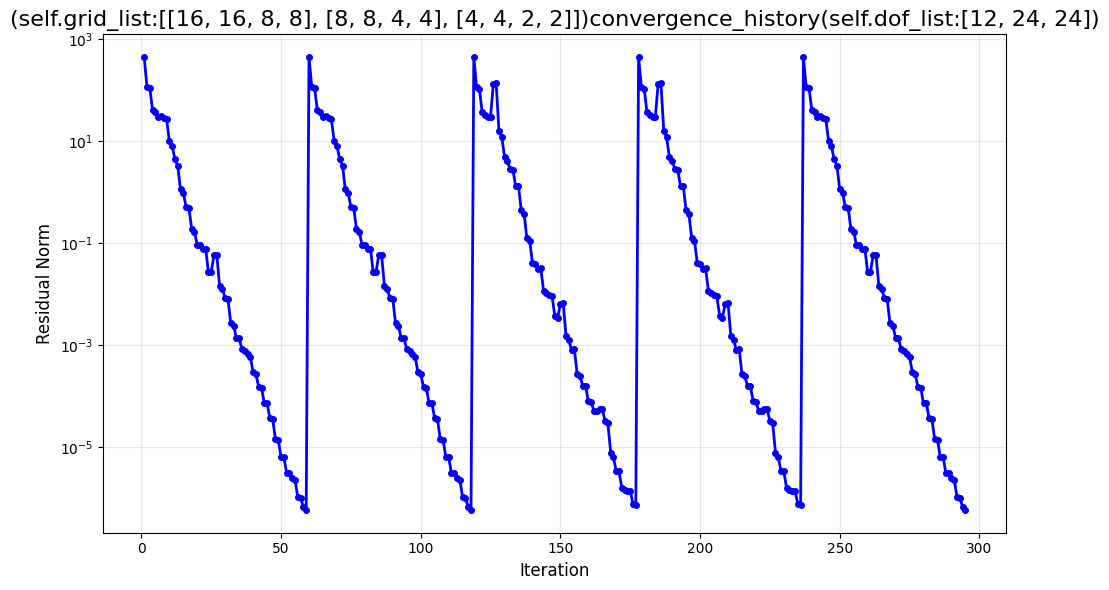

In [23]:
mg.num_levels = 3
x = mg.solve()
mg.plot()

In [10]:
mg.lonv_list[0].shape

torch.Size([24, 12, 4, 2, 4, 2, 8, 2, 8, 2])

In [11]:
(mg.b_list[0]-mg.op_list[0].matvec(x.reshape([12]+list(x.shape[-4:])))).flatten()[:100]

tensor([ 5.6527e-10-3.3218e-10j, -7.2490e-10-2.3061e-09j,
        -5.0281e-10-9.4396e-10j, -7.5067e-10-1.7047e-09j,
        -6.7822e-11-1.8524e-09j, -1.7588e-09-1.2068e-09j,
        -4.5830e-10-2.2631e-09j, -1.7195e-09-3.8453e-10j,
        -1.1631e-09-1.3572e-09j, -1.7983e-09-1.2107e-09j,
        -1.1274e-09-2.1544e-09j, -9.5759e-10-1.7149e-09j,
        -3.8485e-10-1.4119e-09j, -9.7387e-10-1.4136e-09j,
        -1.1770e-09-1.6259e-09j, -7.9870e-10-2.0856e-09j,
         4.2885e-10-7.0422e-10j, -1.2402e-10+5.0309e-10j,
        -3.4663e-10-1.4219e-10j, -6.7581e-10-1.1039e-09j,
        -5.5247e-10-2.5317e-09j, -7.5749e-10-2.7808e-09j,
        -1.1032e-09-1.5879e-09j, -1.1368e-10-1.5112e-09j,
        -8.5218e-10-6.9919e-10j, -5.9676e-10-1.4178e-09j,
        -2.1100e-09-3.4720e-11j,  3.4218e-10-8.8087e-10j,
        -6.7672e-10-6.6912e-10j, -2.1050e-11-6.7481e-10j,
        -5.1434e-10-1.4127e-09j, -1.9929e-10-4.8409e-10j,
         3.2926e-10+5.7815e-10j,  2.5623e-10-1.1569e-09j,
        -3.672

In [12]:
print(torch.norm(x-_x).item()/torch.norm(_x).item())

1.1963848247291168e-07


In [13]:
mg.num_levels

3

In [14]:
index = 0
null_vecs = mg.nv_list[index]
matvec = mg.op_list[index].matvec
for i in range(null_vecs.shape[0]):
    print(
        f"(matvec(null_vecs[i])/null_vecs[i]).flatten()[:10]:{(matvec(null_vecs[i])/null_vecs[i]).flatten()[:10]}")

(matvec(null_vecs[i])/null_vecs[i]).flatten()[:10]:tensor([0.0296+0.0016j, 0.0268+0.0035j, 0.0228-0.0055j, 0.0195-0.0033j,
        0.0123-0.0108j, 0.0092-0.0096j, 0.0002-0.0096j, 0.0063-0.0156j,
        0.0016-0.0049j, 0.0088-0.0107j], device='cuda:0',
       dtype=torch.complex128)
(matvec(null_vecs[i])/null_vecs[i]).flatten()[:10]:tensor([ 0.0046+0.0037j, -0.0003+0.0039j,  0.0021+0.0050j,  0.0003+0.0011j,
         0.0031+0.0045j,  0.0115+0.0014j,  0.0145+0.0001j,  0.0201+0.0038j,
         0.0225+0.0008j,  0.0235+0.0036j], device='cuda:0',
       dtype=torch.complex128)
(matvec(null_vecs[i])/null_vecs[i]).flatten()[:10]:tensor([-0.0019-0.0043j,  0.0248-0.0044j, -0.0126+0.0054j,  0.0135-0.0077j,
        -0.0223-0.0049j,  0.0100+0.0100j,  0.0096+0.0108j,  0.0068+0.0246j,
         0.0207+0.0098j,  0.0125+0.0139j], device='cuda:0',
       dtype=torch.complex128)
(matvec(null_vecs[i])/null_vecs[i]).flatten()[:10]:tensor([0.0197-0.0094j, 0.0230-0.0060j, 0.0250-0.0081j, 0.0244-0.0070j,
     

In [15]:
mg.nv_list[-1].flatten()[:100]

tensor([-0.0080-0.0031j, -0.0078-0.0028j, -0.0083-0.0040j, -0.0087-0.0056j,
        -0.0101-0.0064j, -0.0111-0.0061j, -0.0115-0.0051j, -0.0102-0.0045j,
        -0.0089-0.0031j, -0.0083-0.0027j, -0.0087-0.0034j, -0.0099-0.0052j,
        -0.0116-0.0060j, -0.0127-0.0057j, -0.0127-0.0047j, -0.0106-0.0045j,
        -0.0091-0.0042j, -0.0081-0.0038j, -0.0087-0.0045j, -0.0109-0.0052j,
        -0.0127-0.0056j, -0.0135-0.0048j, -0.0119-0.0044j, -0.0113-0.0037j,
        -0.0095-0.0050j, -0.0080-0.0047j, -0.0092-0.0056j, -0.0105-0.0064j,
        -0.0119-0.0071j, -0.0119-0.0057j, -0.0108-0.0052j, -0.0105-0.0047j,
        -0.0080-0.0054j, -0.0070-0.0063j, -0.0081-0.0075j, -0.0099-0.0080j,
        -0.0113-0.0080j, -0.0118-0.0065j, -0.0103-0.0054j, -0.0094-0.0054j,
        -0.0064-0.0050j, -0.0060-0.0064j, -0.0071-0.0079j, -0.0091-0.0082j,
        -0.0104-0.0080j, -0.0103-0.0069j, -0.0093-0.0056j, -0.0083-0.0049j,
        -0.0060-0.0040j, -0.0063-0.0052j, -0.0068-0.0068j, -0.0085-0.0071j,
        -0.0

In [16]:
_null_vec = torch.randn_like(null_vecs[0])
print(torch.norm(matvec(_null_vec)))
print(matvec(_null_vec).flatten()[:20])
_null_vec -= inverse.bicgstab(b=matvec(_null_vec), matvec=matvec, tol=5e-5)
print(torch.norm(_null_vec))
print(_null_vec.flatten()[:20])
_null_vec/=torch.norm(_null_vec).item()
print(
    f"(matvec(_null_vec)/_null_vec).flatten()[:10]:{(matvec(_null_vec)/_null_vec).flatten()[:10]}")

tensor(495.5740, device='cuda:0', dtype=torch.float64)
tensor([-0.9301+0.1655j,  1.0642-1.0187j,  0.1578+1.7385j,  0.5534-1.1811j,
        -0.0530+0.5550j, -0.6252-2.5803j, -0.7322+0.5883j, -0.0252+0.1804j,
        -0.1422-0.0628j,  0.1513+0.6382j, -0.6308-0.2544j,  0.5003-0.1291j,
         0.8846+0.3306j, -0.4361+1.0535j, -0.1540-0.7522j, -0.1224+0.5302j,
         1.7814-0.0420j,  0.8128-0.7382j, -0.0912+0.3307j, -0.5397+1.0378j],
       device='cuda:0', dtype=torch.complex128)
Norm of b:495.5739925627657
Norm of r:700.4224887099971
Norm of x0:442.8708318604005
BICGSTAB-Iteration 0: Residual = 1.207991e+02, Time = 0.012998 s
BICGSTAB-Iteration 1: Residual = 3.949643e+01, Time = 0.013132 s
BICGSTAB-Iteration 2: Residual = 6.373624e+01, Time = 0.013589 s
BICGSTAB-Iteration 3: Residual = 1.318824e+01, Time = 0.013540 s
BICGSTAB-Iteration 4: Residual = 8.461982e+00, Time = 0.013525 s
BICGSTAB-Iteration 5: Residual = 6.393645e+00, Time = 0.014366 s
BICGSTAB-Iteration 6: Residual = 5.521805

In [17]:
_b = torch.randn_like(null_vecs[0])
_x = inverse.bicgstab(b=_b, matvec=matvec, tol=1e-8)
print((_b-matvec(_x)).flatten()[:100])
print(torch.norm(_b))
print(torch.norm(_x))

Norm of b:443.7193747128637
Norm of r:667.0894137743694
Norm of x0:443.6490785219461
BICGSTAB-Iteration 0: Residual = 1.437567e+02, Time = 0.013190 s
BICGSTAB-Iteration 1: Residual = 6.095761e+01, Time = 0.013862 s
BICGSTAB-Iteration 2: Residual = 6.590105e+01, Time = 0.013324 s
BICGSTAB-Iteration 3: Residual = 3.984279e+01, Time = 0.012935 s
BICGSTAB-Iteration 4: Residual = 2.485570e+01, Time = 0.014324 s
BICGSTAB-Iteration 5: Residual = 1.821586e+01, Time = 0.014002 s
BICGSTAB-Iteration 6: Residual = 1.743107e+01, Time = 0.014564 s
BICGSTAB-Iteration 7: Residual = 2.195824e+01, Time = 0.013788 s
BICGSTAB-Iteration 8: Residual = 1.258354e+01, Time = 0.014046 s
BICGSTAB-Iteration 9: Residual = 9.737644e+00, Time = 0.013826 s
BICGSTAB-Iteration 10: Residual = 2.180089e+01, Time = 0.013175 s
BICGSTAB-Iteration 11: Residual = 7.768428e+00, Time = 0.013885 s
BICGSTAB-Iteration 12: Residual = 4.819202e+00, Time = 0.013969 s
BICGSTAB-Iteration 13: Residual = 4.370855e+00, Time = 0.013209 s
B

In [18]:
_null_vec.flatten()[:100]

tensor([ 0.0009-0.0014j,  0.0007-0.0008j,  0.0003-0.0008j,  0.0004-0.0003j,
         0.0007-0.0003j,  0.0005-0.0010j, -0.0002-0.0010j,  0.0006-0.0006j,
         0.0007-0.0002j,  0.0004-0.0004j,  0.0010-0.0004j,  0.0014-0.0005j,
         0.0013-0.0004j,  0.0012-0.0007j,  0.0011-0.0005j,  0.0013-0.0007j,
         0.0014-0.0007j,  0.0005-0.0004j,  0.0003-0.0007j,  0.0006-0.0005j,
         0.0005-0.0012j,  0.0007-0.0011j,  0.0007-0.0007j,  0.0008-0.0005j,
         0.0004-0.0006j,  0.0008-0.0005j,  0.0013-0.0005j,  0.0012-0.0009j,
         0.0015-0.0009j,  0.0013-0.0002j,  0.0013-0.0009j,  0.0013-0.0008j,
         0.0006-0.0009j,  0.0008-0.0008j,  0.0006-0.0007j,  0.0012-0.0004j,
         0.0008-0.0007j,  0.0007-0.0007j,  0.0009-0.0005j,  0.0005-0.0005j,
         0.0007-0.0004j,  0.0011-0.0006j,  0.0010-0.0002j,  0.0015-0.0006j,
         0.0010-0.0010j,  0.0013-0.0008j,  0.0011-0.0008j,  0.0008-0.0008j,
         0.0007-0.0009j,  0.0007-0.0008j,  0.0010-0.0007j,  0.0009-0.0006j,
         0.0